In [1]:
from pathlib import Path
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
root = Path("../Data/artrium_segmentation/imagesTr")
label = Path("../Data/artrium_segmentation/labelsTr")

In [3]:
def change_img_path_label_path(path):
    parts = list(path.parts)
    parts[parts.index("imagesTr")] = "labelsTr"
    return Path(*parts)

In [4]:
sample_path = list(root.glob("la*"))[0]
sample_label_path = change_img_path_label_path(sample_path)

In [5]:
sample_path, sample_label_path

(PosixPath('../Data/artrium_segmentation/imagesTr/la_003.nii.gz'),
 PosixPath('../Data/artrium_segmentation/labelsTr/la_003.nii.gz'))

In [6]:
data = nib.load(sample_path)
label = nib.load(sample_label_path)

mri = data.get_fdata()
mask = label.get_fdata()

In [7]:
from celluloid import Camera
from IPython.display import HTML

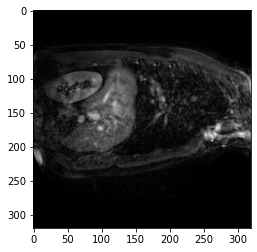

In [8]:
fig = plt.figure()
camera = Camera(fig)

for i in range(mri.shape[2]):
    plt.imshow(mri[:, :, i], cmap="gray")
    mask_ = np.ma.masked_where(mask[:, :, i] == 0, mask[:, :, i])
    plt.imshow(mask_, alpha=0.4)
    camera.snap()

animation = camera.animate()

In [9]:
HTML(animation.to_html5_video())

In [10]:
def normalize_data(full_volume):
    mu = full_volume.mean()
    std = np.std(full_volume)
    normalized = (full_volume - mu) / std
    return normalized

def standardize(normalized):
    standardized = (normalized - normalized.min()) / (normalized.max() - normalized.min())
    return standardized

In [11]:
all_files = list(root.glob("la*"))
len(all_files)

20

In [12]:
save_root = Path("../Data/artrium_segmentation/processed")

for counter, mri_data_path in enumerate(tqdm(all_files)):
    path_to_label = change_img_path_label_path(mri_data_path)

    mri = nib.load(mri_data_path)

    assert nib.aff2axcodes(mri.affine) == ("R", "A", "S")
    mri_data = mri.get_fdata()
    label_data = nib.load(path_to_label).get_fdata().astype(np.uint8)

    mri_data = mri_data[32:-32, 32:-32]
    label_data = label_data[32:-32, 32:-32]

    normalized_mri_data = normalize_data(mri_data)
    standardized_mri_data = standardize(normalized_mri_data)

    if counter < 17:
        current_path = save_root/"train"/str(counter)
    else:
        current_path = save_root/"val"/str(counter)

    for i in range(standardized_mri_data.shape[-1]):
        slice = standardized_mri_data[:,:,i]
        mask = label_data[:, :, i]
        slice_path = current_path/"data"
        mask_path = current_path/"masks"
        
        slice_path.mkdir(parents=True, exist_ok=True)
        mask_path.mkdir(parents=True, exist_ok=True)
        
        np.save(slice_path/str(i), slice)
        np.save(mask_path/str(i), mask)


  0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 20/20 [00:28<00:00,  1.44s/it]


## Visualize the data

In [2]:
path = Path("../Data/artrium_segmentation/processed/train/0")

file = "67.npy"

slice = np.load(path/"data"/file)
mask = np.load(path/"masks"/file)

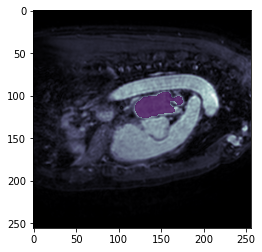

In [3]:
plt.imshow(slice, cmap="bone")
mask_ = np.ma.masked_where(mask==0, mask)
plt.imshow(mask_, alpha=0.7)

In [5]:
mask.sum()

1219